Max Schrader

ME 591

## Python Packages

In [1]:
import os
import pandas as pd
from scipy import integrate
from numpy import random, std
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

## Loading in the [Argonne National Lab's Conventional Vehicle Testing Dataset](https://www.anl.gov/es/conventional-vehicle-testing)

In [2]:
PATH = !pwd  # a bit of Jupyter Magic to get the working path
PATH = os.path.join(*os.path.split(PATH[0])[:-1])

# SSS, 55MPH 10 minute warmup
static_55_path = os.path.join(PATH, 'hw2', 'data', '61704046 Test Data.txt')

# US06x2, 4 (split) bag, warm start
us06_path = os.path.join(PATH, 'hw2', 'data', '61704021 Test Data.txt')

In [3]:
static_55_df = pd.read_csv(static_55_path, header=0, sep='\t')
# filtering out the non-SS data
static_55_df = static_55_df.loc[static_55_df['Dyno_Spd[mph]'] >= 54].iloc[50:]

us06_df = pd.read_csv(us06_path, header=0, sep='\t')
# begining at the test start (0seconds, data recording starts at -30) and lasting one us06 cycle
us06_df = us06_df.loc[(us06_df['Time[s]_RawFacilities'] >= 0) & (us06_df['Time[s]_RawFacilities'] < 600)]

# Question 1

The parameter considered for this assignment is **total fuel consumption**, which emulates a calculation that I will be doing in the coming months. Total fuel consumption, in my case, will be calculated by integrating the fuel flow throughout the drive cycle. In practice, an inline flow meter ([AVL PLUtron](https://www.avl.com/-/avl-plutron)) will be mounted on a 2020 Mercedes GLE probe vehicle. However, the research project is not in the stages where data can be gathered from the experimental setup, and thus 2016 Mazda CX9 data from the [Argonne National Lab's Conventional Vehicle Testing](https://www.anl.gov/es/conventional-vehicle-testing) dataset is used in this assigment. Specifically, two datasets are used: a static 55mph warm-up cycle, and a US06 drive cycle. Both were driven on a chassis dynamometer  

The equation for **Total Fuel Consumption, $V_{total}$** is a function of fuel flow, $Q(t)$:

$$V_{total} = \int_{t_0}^{t_{final}} Q(t)dt$$

$Q(t)$ is comprised of the true value and some uncertainty, $u_V$. Because the underlying function representating fuel flow during a drive cycle is unknown, total fuel consumption can only be determined via numerical methods. One of the common methods for numeric integration is the trapezoidal method. 

$$\int_{t_0}^{t_n} Q(t)\, dt \approx \sum_{i=1}^n \frac{Q_{i-1} + Q_i}{2} \Delta t_i,$$

Using the trapezoidal method, discrete fuel flow measurements can be integrated to approximate total fuel volume, but uncertainty must be propogated through the calculations

### Sample Measurements

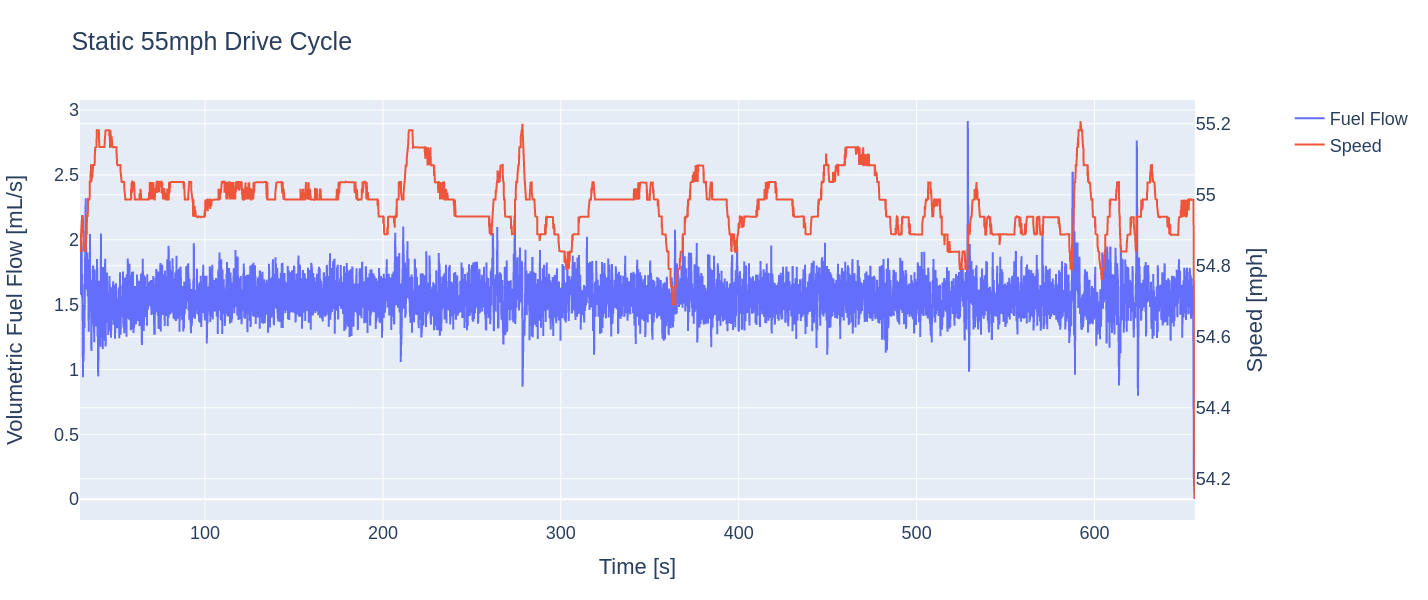

Mean of "static" fuel flow measurement: 1.5534685705169113
Standard Deviation of "static" fuel flow measurement: 0.15500032829810856


In [4]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=static_55_df['Time[s]_RawFacilities'], y=static_55_df['Eng_FuelFlow_Direct[ccps]'], name='Fuel Flow'))
fig.add_trace(go.Scatter(x=static_55_df['Time[s]_RawFacilities'], y=static_55_df['Dyno_Spd[mph]'], name='Speed'), secondary_y=True,)
fig.update_layout(title="Static 55mph Drive Cycle", yaxis_title="Volumetric Fuel Flow [mL/s]", xaxis_title="Time [s]")
fig.update_yaxes(title_text="Speed [mph]", secondary_y=True)
fig.update_layout(font_size=18)
fig.update_layout(height=600, width=1200)
fig.show()
print('Mean of "static" fuel flow measurement:', static_55_df['Eng_FuelFlow_Direct[ccps]'].mean())
print('Standard Deviation of "static" fuel flow measurement:', static_55_df['Eng_FuelFlow_Direct[ccps]'].std())

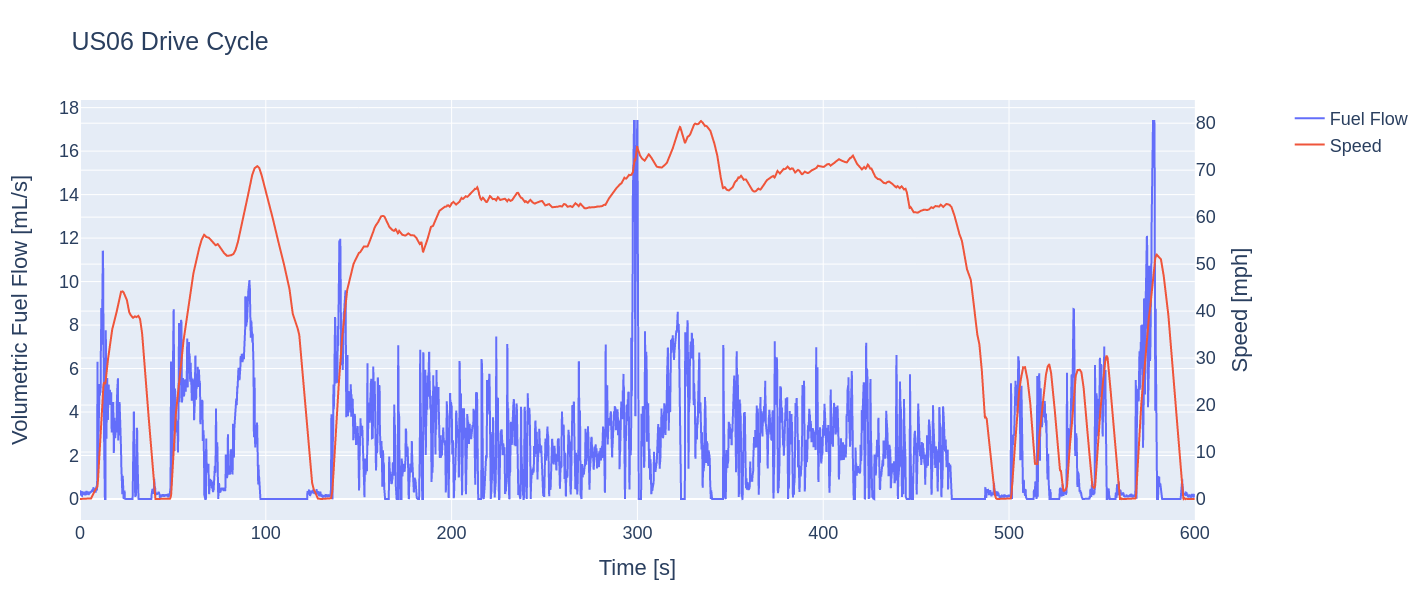

In [5]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['Eng_FuelFlow_Direct[ccps]'], name='Fuel Flow'))
fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['Dyno_Spd[mph]'], name='Speed'), secondary_y=True,)
fig.update_layout(title="US06 Drive Cycle", yaxis_title="Volumetric Fuel Flow [mL/s]", xaxis_title="Time [s]")
fig.update_yaxes(title_text="Speed [mph]", secondary_y=True)
fig.update_layout(font_size=18)
fig.update_layout(height=600, width=1200)
fig.show()

# Question 2

Per the Plutron manual, its uncertainty can be summarized as:

Bias uncertainty: $u_B = 0.3 \%$ of the measured value

Resolution uncertainty: $u_{resolution} = 0.05\text{mm}^3 = 0.05\text{x10}^{-6}L = 0.05\text{x10}^{-3}mL$

Precision uncertainty: $u_p = 0.1550 \frac{mL}{s}$

* Note about the precision uncertainty: It was calculated by taking the standard deviation of the volumetric fuel flow in the static 55 mph drive cycle. This is definitely not a static fuel flow, one example being the variable auxilary loads on the engine. I used it to calculate precision uncertainty only for the purposes of creating a value for this assignment 


# Question 3

Before the error propogation begins, it is important to note a few assumptions:
1. There is no error in $t$
2. The autocorrelation (time series covariance) between consecutive volumetric flow measurements is 0, ie. $\mathrm{Cor}[V_t, V_{t+1}] = 0$
3. I am ignoring the error inherint to the trapezoidal method itself 

Total fuel volume can be defined as:
$$V = \int_{t_0}^{t_n} Q(t)\, dt \approx \sum_{t=1}^n \frac{Q_{t-1} + Q_t}{2} \Delta t_i,$$

With a constant $\Delta t$, the trapezoidal method simplifies to

$$V = \int_{t_0}^{t_n} Q(t)\, dt \approx \tfrac{\Delta t}{2}\left(Q_0 + 2Q_1+2Q_2 + \cdots+2Q_{t-1} + Q_n\right)$$

The general equation for uncertainty, ignoring covariance, is

$$u_f^2=\sum_{x_i}\left|\frac{\partial f}{\partial x_i}\right| u_{x_i}^2$$

then, taking partial derivatives of the trapezoid method from above, the equation for uncertainty becomes

$$u_f^2 = \frac{\partial V}{\partial Q_0}^2 u_{0}^{2} + \frac{\partial V}{\partial Q_1}^2 u_{1}^{2} + \cdots + \frac{\partial V}{\partial Q_n}^2 u_{n}^{2} = \frac{\Delta t^2}{4} u_0^2 + \frac{\Delta t^2}{2} u_1^2 + \cdots \frac{\Delta t^2}{4} u_n^2$$

simplifying:

$$u_f = \sqrt{\sum_{t=1}^n \frac{u_{t-1}^2 + u_t^2}{4} \Delta t_i^2}$$

Uncertainty in each volumetric flow measurement, $u_t$, consists of bias uncertainty, $u_B$, and random uncertainty, $u_P$ and is the root sum of their squares

$$u_t = \sqrt{u_{B}^{2} + u_{P}^{2}}$$

where,

$$u_B = 0.3\% (Q_t) + 0.05\text{x10}^{-3}$$

Carrying the units through,

$$u_v \left[\frac{mL}{s}\right]= \sqrt{{u_{B} \left[\frac{mL}{s}\right]}^{2} + {u_{P} \left[\frac{mL}{s}\right]}^{2}}$$

and the total uncertainty equation:

$$u_f [mL] = \sqrt{\sum_{t=1}^n \frac{{u_{t-1}\left[\frac{mL}{s}\right]}^2 + {u_t \left[\frac{mL}{s}\right]}^2}{4} \Delta t_i [s]^2}$$

Sources:
1. https://www.researchgate.net/publication/231019084_Uncertainty_propagation_through_polynomial_fitting_and_integration_procedures_with_GUM_and_Monte_Carlo_applied_to_x-ray_streak_camera_yield_measurements
2. https://stats.stackexchange.com/questions/214850/propagate-errors-in-measured-points-to-simpsons-numerical-integral

# Question 4


## Bias and Precision Uncertainty 

$$u_B = 0.3\% (Q_t [mL]) + 0.05\text{x10}^{-3}[mL]$$

$$u_P = 0.155 [mL]$$

$$u_t = \sqrt{u_{B}^{2} + u_{P}^{2}}$$

## Calculating the time-variant uncertainty

In [6]:
us06_df['u_t'] = ((abs(us06_df['Eng_FuelFlow_Direct[ccps]'] * 0.003) + 0.05e-3)**2 + (0.155)**2)**(1/2)
us06_df['u_t^2'] = us06_df['u_t']**2

## Finding the total uncertainty 

### Finding $\Delta t$

In [7]:
dt = us06_df['Time[s]_RawFacilities'].iloc[1] - us06_df['Time[s]_RawFacilities'].iloc[0]
print('dt =', dt)

dt = 0.1


### Calculating $u_V$

In [16]:
u_v = (((us06_df['u_t^2'] + us06_df['u_t^2'].shift(1)) / 4).fillna(0).cumsum() * dt**2)**(1/2)
u_v_final = u_v.iloc[-1]
print(f"u_v = {round(u_v_final, 3)} [mL] or {round(u_v_final* 0.000264172, 6)} [gal]")  # this seems incredibly small

u_v = 0.851 [mL] or 0.000225 [gal]


### Calculating total fuel consumption

In [9]:
us06_df['cc_fuel'] = integrate.cumtrapz(us06_df['Eng_FuelFlow_Direct[ccps]'], dx=dt, initial=0)
print("gallons of fuel consumed = ", us06_df['cc_fuel'].iloc[-1] * 0.000264172)

gallons of fuel consumed =  0.36340625692720047


### Plotting total fuel consumption

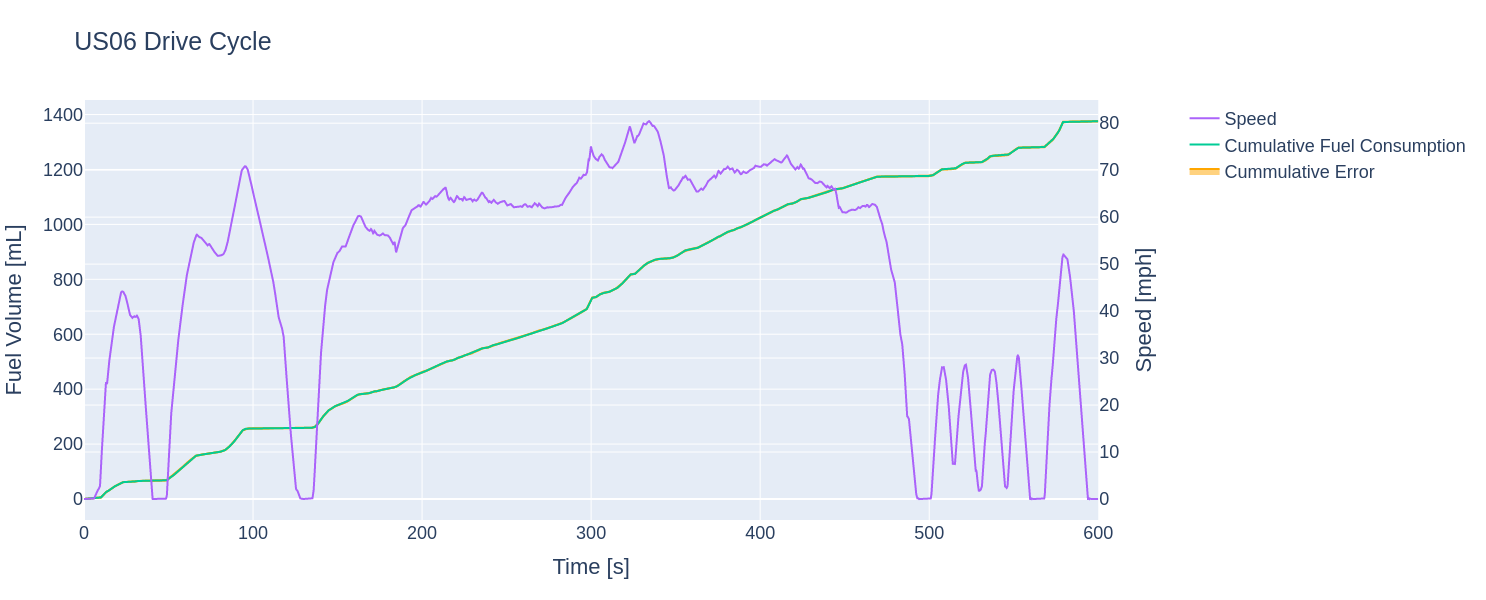

In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=us06_df['Time[s]_RawFacilities'],
        y=us06_df['cc_fuel'] + u_v,
#         name="Cummulative Error",
        showlegend=False,
        line=dict(color='#ffa600')
    ),
)

fig.add_trace(
    go.Scatter(
        x=us06_df['Time[s]_RawFacilities'],
        y=us06_df['cc_fuel'] - u_v,
        name="Cummulative Error",
        line=dict(color='#ffa600'),
        fill='tonexty'
    ),
)

fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['cc_fuel'], name='Cumulative Fuel Consumption'))
fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['Dyno_Spd[mph]'], name='Speed'), secondary_y=True,)
fig.update_layout(title="US06 Drive Cycle", yaxis_title="Fuel Volume [mL]", xaxis_title="Time [s]")
fig.update_yaxes(title_text="Speed [mph]", secondary_y=True)
fig.update_layout(font_size=18)
fig.update_layout(height=600, width=1200)
fig.show()

Cumulative error is not visible in the plot, as it is so small relative to the total fuel consumption 

### Plotting Uncertainty in Each Measurement

Zooming in to see the "error bars" in each measurement

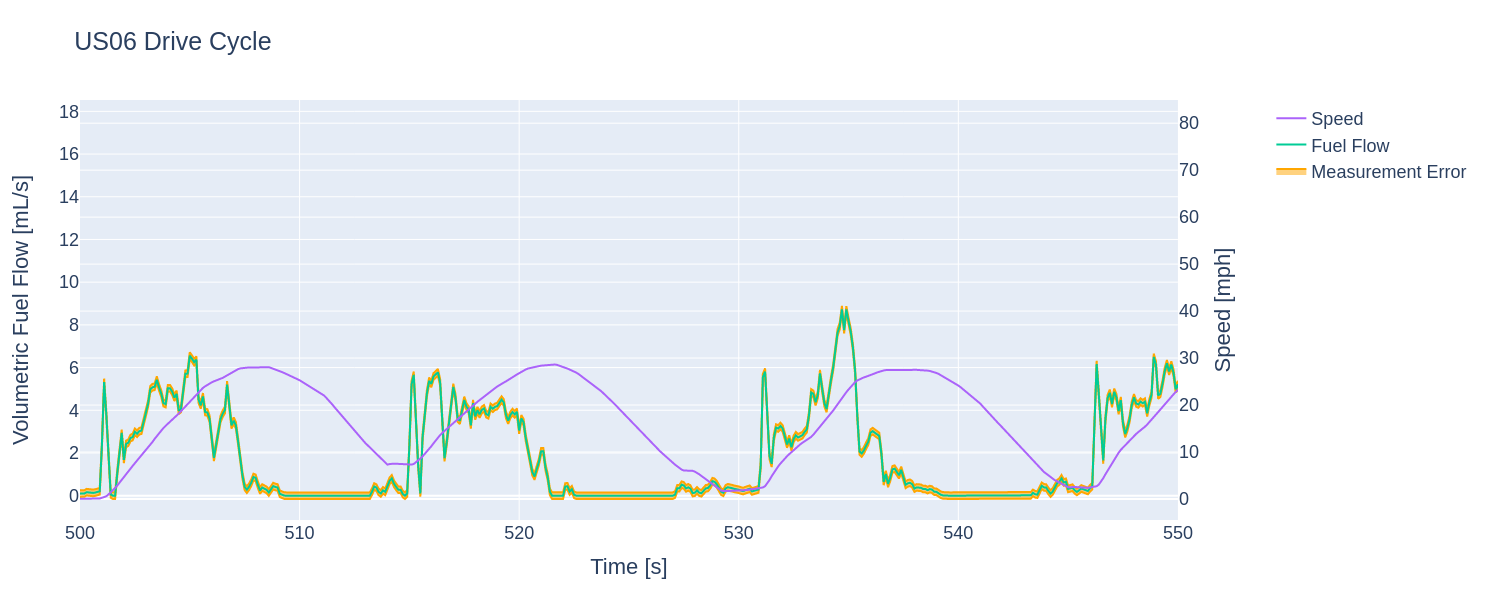

In [27]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=us06_df['Time[s]_RawFacilities'],
        y=us06_df['Eng_FuelFlow_Direct[ccps]'] + us06_df['u_t'],
#         name="Cummulative Error",
        showlegend=False,
        line=dict(color='#ffa600')
    ),
)

fig.add_trace(
    go.Scatter(
        x=us06_df['Time[s]_RawFacilities'],
        y=us06_df['Eng_FuelFlow_Direct[ccps]'] - us06_df['u_t'],
        name="Measurement Error",
        line=dict(color='#ffa600'),
        fill='tonexty'
    ),
)

fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['Eng_FuelFlow_Direct[ccps]'], name='Fuel Flow'))
fig.add_trace(go.Scatter(x=us06_df['Time[s]_RawFacilities'], y=us06_df['Dyno_Spd[mph]'], name='Speed'), secondary_y=True,)
fig.update_layout(title="US06 Drive Cycle", yaxis_title="Volumetric Fuel Flow [mL/s]", xaxis_title="Time [s]")
fig.update_yaxes(title_text="Speed [mph]", secondary_y=True)
fig.update_layout(font_size=18)
fig.update_layout(height=600, width=1200)
fig.update_layout(xaxis_range=[500, 550])
fig.show()

## Monte Carlo Method

We assume that the precision bias is guassian distributed

The true value is the integrated fuel consumption line by which to apply the variance too

In [41]:
import multiprocessing as mp

normal_func = random.normal
uniform_func = random.uniform
cumtrapz_func = integrate.cumtrapz

def mp_func(queue, iterations):
    holder = []
    for _ in range(iterations):
        new_fuel_flow = us06_df['Eng_FuelFlow_Direct[ccps]'].copy().apply(lambda x: x + (uniform_func(low=x * -0.003, high=x * 0.003) + uniform_func(low=0, high=0.005e-3) + normal_func(scale=0.155)))
        holder.append(cumtrapz_func(new_fuel_flow, dx=dt, initial=0))
    queue.put([hold[-1] for hold in holder])

In [42]:
SIMS = 1000

iterations_per_cpu = int(SIMS / mp.cpu_count())

q = mp.Queue()
processes = []
for _ in range(mp.cpu_count()):
    p = mp.Process(target=mp_func, args=(q, iterations_per_cpu))
    processes.append(p)
    p.start()

holder = []
for p in processes:
    holder.extend(q.get())
for p in processes:
    p.join()

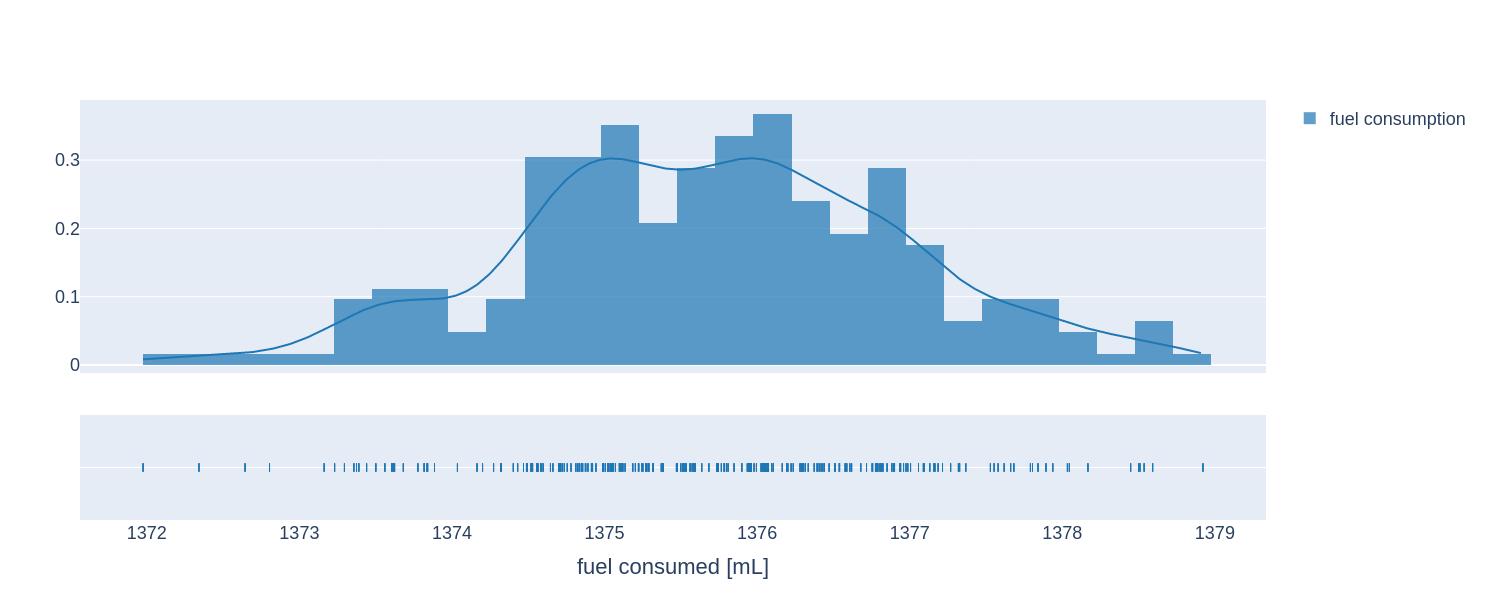

In [43]:
fig = go.Figure()
fig = ff.create_distplot([holder], group_labels=['fuel consumption'], bin_size=0.25)
# fig.add_trace(go.Histogram(x=[hold[-1] for hold in holder]))
fig.update_layout(xaxis_title="fuel consumed [mL]")
fig.update_layout(font_size=18)
fig.update_layout(height=600, width=1200)
fig.show()

In [45]:
print(f"The average fuel consumption [gal] of {SIMS} monte carlo simulations is ", sum(holder) / len(holder) * 0.000264172)
print(f"The standard deviation [mL] is {round(std(holder), 3)} or {round(std(holder) * 0.000264172, 6)} [gal]")

The average fuel consumption [gal] of 1000 monte carlo simulations is  0.36341686352781305
The standard deviation [mL] is 1.258 or 0.000332 [gal]


Per data from , the total fuel consumed during the drive **0.35639702 gal**, which differs by 7.1E-3 gallons or 22.5! standard deviations from my Montecarlo fuel consumption estimation. The error is likely window based, as I am guessing the reported fuel consumption came from 0-600S, but not entirely sure...